# Weather Data Collection for PJM inter connected Grid

In this Jupyter notebook weather data is collected for use in a project designed to find relationships between power and weather
Most weather websites used data collected at local airports to record and forcast weather for the regionin order to reduce the number of datapoints location data for airports has been downloaded from datahub
the airport locations will be culled for those regions who are in the PJM service area
the API being used limits historical calls to 31 day intervals and returns hourly data. in order to collect data for a full year data will need to be called multiple times. 


In [65]:

#import necessary libraries 
import time 
import datetime
from dateutil.rrule import rrule, DAILY, MONTHLY
from datetime import  timedelta
import json, csv
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import timeit
from decimal import Decimal

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.6f}'.format


In [66]:
#import the airport-codes_csv.csv
# https://datahub.io/core/airport-codes#resource-airport-codes
Airport_codes_df = pd.read_csv('/Users/robertshiles/CSV_files/airport-codes_csv.csv',encoding= 'latin1')
Airport_codes_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.000000,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,"3,435.000000",NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.000000,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.000000,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.000000,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [67]:
# Ohio   
# DC
# West Virgina
# Virginia
# Pennsylvania
# Deleware
# New JErsy
# Marryland
# Eastern Kentucky 
# Eastern indiana
# south western michigan 
# Northcentral/eastern Illiniose
# north eastern north carolina 

In [68]:
# cull the airport codes to include only large and medium sized airports in the PJM interconection grid 


#remove closed ,heliport, seaplane_base, and possibly small_airport 

included_types=['large_airport','medium_airport']

#get data for Airports in Pennsylvania Maryland NewJersy 
PJM_states=['US-PA','US-MD', 'US-NJ',
            'US-VA', 'US-DE']
#select major and medium sized airports in the states covered by PJM 
pjm_Airport_codes = Airport_codes_df.loc[lambda Airport_codes_df: Airport_codes_df['iso_region'].isin(PJM_states)]
pjm_Airport_codes = pjm_Airport_codes.loc[lambda pjm_Airport_codes:pjm_Airport_codes['type'].isin(included_types)]


#convert the airport coordinated string into two seperate floating numbers for latitude and longituded
pjm_Airport_codes['coordinates'] = pjm_Airport_codes['coordinates'].str.split(',')
pjm_Airport_codes['lon'], pjm_Airport_codes['lat'] = zip(*pjm_Airport_codes.coordinates)

#pjm_Airport_codes['lat'] = f'{pjm_Airport_codes['lat']:.2f}'
#pjm_Airport_codes['lon'] = f'{pjm_Airport_codes['lon']:.2f}'

pjm_Airport_codes['lat'] = pjm_Airport_codes['lat'].astype(float)
pjm_Airport_codes['lon'] = pjm_Airport_codes['lon'].astype(float)


#pjm_Airport_codes['lat'] = pjm_Airport_codes['lat'].apply(lambda x: Decimalx.quantize(Decimal('0.000000')))
#pjm_Airport_codes['lon'] = pjm_Airport_codes['lon'].apply(lambda x: x.quantize(Decimal('0.000000')))

pjm_Airport_codes['lat'] = pjm_Airport_codes['lat'].apply(lambda x: "{:.6f}".format(x))
pjm_Airport_codes['lon'] = pjm_Airport_codes['lon'].apply(lambda x: "{:.6f}".format(x))

#drop rows with empty coordinates 
pjm_Airport_codes = pjm_Airport_codes.dropna(subset=['lat', 'lon','coordinates'])

#reset the index of the new dataframe 
pjm_Airport_codes = pjm_Airport_codes.reset_index(drop=True)

#"{:.2f}".format('lat')
#pjm_Airport_codes['lat'] = pjm_Airport_codes['lat'].round(6)
#pjm_Airport_codes['lon'] = pjm_Airport_codes['lon'].round(6)

#pjm_Airport_codes['cost'].map('{:,.2f}'.format) style.format("{:.2%}")

pjm_Airport_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lon,lat
0,KABE,medium_airport,Lehigh Valley International Airport,393.000000,NaN,US,US-PA,Allentown,KABE,ABE,ABE,"[-75.44080352783203, 40.652099609375]",-75.440804,40.652100
1,KACY,medium_airport,Atlantic City International Airport,75.000000,NaN,US,US-NJ,Atlantic City,KACY,ACY,ACY,"[-74.57720184326172, 39.45759963989258]",-74.577202,39.457600
2,KADW,large_airport,Joint Base Andrews,280.000000,NaN,US,US-MD,Camp Springs,KADW,ADW,ADW,"[-76.866997, 38.810799]",-76.866997,38.810799
3,KAGC,medium_airport,Allegheny County Airport,"1,252.000000",NaN,US,US-PA,Pittsburgh,KAGC,AGC,AGC,"[-79.9301986694336, 40.354400634765625]",-79.930199,40.354401
4,KAOO,medium_airport,Altoona Blair County Airport,"1,503.000000",NaN,US,US-PA,Altoona,KAOO,AOO,AOO,"[-78.31999969, 40.29639816]",-78.320000,40.296398


In [69]:
pjm_Airport_codes.name.unique()

array(['Lehigh Valley International Airport',
       'Atlantic City International Airport', 'Joint Base Andrews',
       'Allegheny County Airport', 'Altoona Blair County Airport',
       'Phillips Army Air Field',
       'Wilkes Barre Scranton International Airport',
       'Bradford Regional Airport', 'Beaver County Airport',
       'Baltimore/Washington International Thurgood Marshall Airport',
       'Charlottesville Albemarle Airport', 'Davison Army Air Field',
       'Danville Regional Airport', 'Dover Air Force Base',
       'DuBois Regional Airport', 'Erie International Tom Ridge Field',
       'Newark Liberty International Airport', 'Felker Army Air Field',
       'Venango Regional Airport', 'Tipton Airport',
       'Hagerstown Regional Richard A Henson Field', 'New Castle Airport',
       'Williamsport Regional Airport',
       'John Murtha Johnstown Cambria County Airport',
       'Arnold Palmer Regional Airport', 'Langley Air Force Base',
       'Lancaster Airport', 'Lynchb

In [70]:
indecies = []
for ind in pjm_Airport_codes.index:
    indecies.append(ind)
print(indecies)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


In [71]:
start = timeit.timeit()

airport_test_url=[]
working = []
num_working = 0
num_broken = 0


for ind in pjm_Airport_codes.index:
    responce  = requests.get('https://api.weather.com/v1/geocode/{}/{}/observations/historical.json?apiKey=6532d6454b8aa370768e63d6ba5a832e&startDate=20181231&endDate=20181231&units=e'.format(pjm_Airport_codes['lat'].iloc[ind],pjm_Airport_codes['lon'].iloc[ind]))
    api = responce.json()
        
    try:
        reading_df = pd.DataFrame(api["observations"])
        #working_airports.append((lat_airport[k],lon_airport[k])) 
        num_working +=1
        working.append(True)
        print('ind{} # working{}#broken{}'.format(ind,num_working,num_broken))
    except KeyError:
        num_broken=+1
        working.append(False)
        print('{}number broken{}'.format(ind,num_broken))
        #if api["errors"]["message"]==('Invalid lat/long specification'):
            #print("bad location{}{}".format(lat_airport[k],lon_airport[k]))
            
        #else:
            
    time.sleep(.1)  

pjm_Airport_codes['working'] = working                           
print("number working{} number broken{}".format(num_working,num_broken))     

#print the elapsed time 
end = timeit.timeit()
print("time:",end - start)
                                  
       

ind0 # working1#broken0
ind1 # working2#broken0
ind2 # working3#broken0
ind3 # working4#broken0
ind4 # working5#broken0
ind5 # working6#broken0
ind6 # working7#broken0
ind7 # working8#broken0
8number broken1
ind9 # working9#broken1
ind10 # working10#broken1
ind11 # working11#broken1
ind12 # working12#broken1
ind13 # working13#broken1
ind14 # working14#broken1
ind15 # working15#broken1
ind16 # working16#broken1
ind17 # working17#broken1
ind18 # working18#broken1
ind19 # working19#broken1
ind20 # working20#broken1
ind21 # working21#broken1
ind22 # working22#broken1
ind23 # working23#broken1
ind24 # working24#broken1
ind25 # working25#broken1
ind26 # working26#broken1
ind27 # working27#broken1
ind28 # working28#broken1
ind29 # working29#broken1
ind30 # working30#broken1
ind31 # working31#broken1
ind32 # working32#broken1
ind33 # working33#broken1
ind34 # working34#broken1
ind35 # working35#broken1
ind36 # working36#broken1
ind37 # working37#broken1
ind38 # working38#broken1
ind39 # workin

In [72]:
pjm_Airport_codes.loc[pjm_Airport_codes.iso_region == 'US-MD'].head(40)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lon,lat,working
2,KADW,large_airport,Joint Base Andrews,280.000000,NaN,US,US-MD,Camp Springs,KADW,ADW,ADW,"[-76.866997, 38.810799]",-76.866997,38.810799,True
5,KAPG,medium_airport,Phillips Army Air Field,57.000000,NaN,US,US-MD,Aberdeen Proving Grounds(Aberdeen),KAPG,APG,APG,"[-76.1688, 39.466202]",-76.168800,39.466202,True
9,KBWI,large_airport,Baltimore/Washington International Thurgood Ma...,146.000000,NaN,US,US-MD,Baltimore,KBWI,BWI,BWI,"[-76.668297, 39.1754]",-76.668297,39.175400,True
19,KFME,medium_airport,Tipton Airport,150.000000,NaN,US,US-MD,Fort Meade(Odenton),KFME,FME,FME,"[-76.7593994141, 39.08539962769999]",-76.759399,39.085400,True
20,KHGR,medium_airport,Hagerstown Regional Richard A Henson Field,703.000000,NaN,US,US-MD,Hagerstown,KHGR,HGR,HGR,"[-77.72949982, 39.707901]",-77.729500,39.707901,True
31,KMTN,medium_airport,Martin State Airport,21.000000,NaN,US,US-MD,Baltimore,KMTN,MTN,MTN,"[-76.413803, 39.325699]",-76.413803,39.325699,True
35,KNHK,medium_airport,Patuxent River Naval Air Station (Trapnell Field),39.000000,NaN,US,US-MD,Patuxent River,KNHK,NHK,NHK,"[-76.411797, 38.285999]",-76.411797,38.285999,True
46,KSBY,medium_airport,Salisbury Ocean City Wicomico Regional Airport,52.000000,NaN,US,US-MD,Salisbury,KSBY,SBY,SBY,"[-75.51029968261719, 38.34049987792969]",-75.510300,38.340500,True


In [73]:
#Cull the airports
#list of airports to use
use_these = ['KPHL','KDOV','KEWR','KORF','KACY','KSBY']
pjm_Airport_codes = pjm_Airport_codes.loc[pjm_Airport_codes.ident.isin(use_these)]
pjm_Airport_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lon,lat,working
1,KACY,medium_airport,Atlantic City International Airport,75.000000,NaN,US,US-NJ,Atlantic City,KACY,ACY,ACY,"[-74.57720184326172, 39.45759963989258]",-74.577202,39.457600,True
13,KDOV,large_airport,Dover Air Force Base,24.000000,NaN,US,US-DE,Dover,KDOV,DOV,DOV,"[-75.46600342, 39.12950134]",-75.466003,39.129501,True
16,KEWR,large_airport,Newark Liberty International Airport,18.000000,NaN,US,US-NJ,Newark,KEWR,EWR,EWR,"[-74.168701171875, 40.692501068115234]",-74.168701,40.692501,True
38,KORF,large_airport,Norfolk International Airport,26.000000,NaN,US,US-VA,Norfolk,KORF,ORF,ORF,"[-76.20120239257812, 36.89459991455078]",-76.201202,36.894600,True
40,KPHL,large_airport,Philadelphia International Airport,36.000000,NaN,US,US-PA,Philadelphia,KPHL,PHL,PHL,"[-75.24109649658203, 39.87189865112305]",-75.241096,39.871899,True


/Users/robertshiles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/robertshiles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/robertshiles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


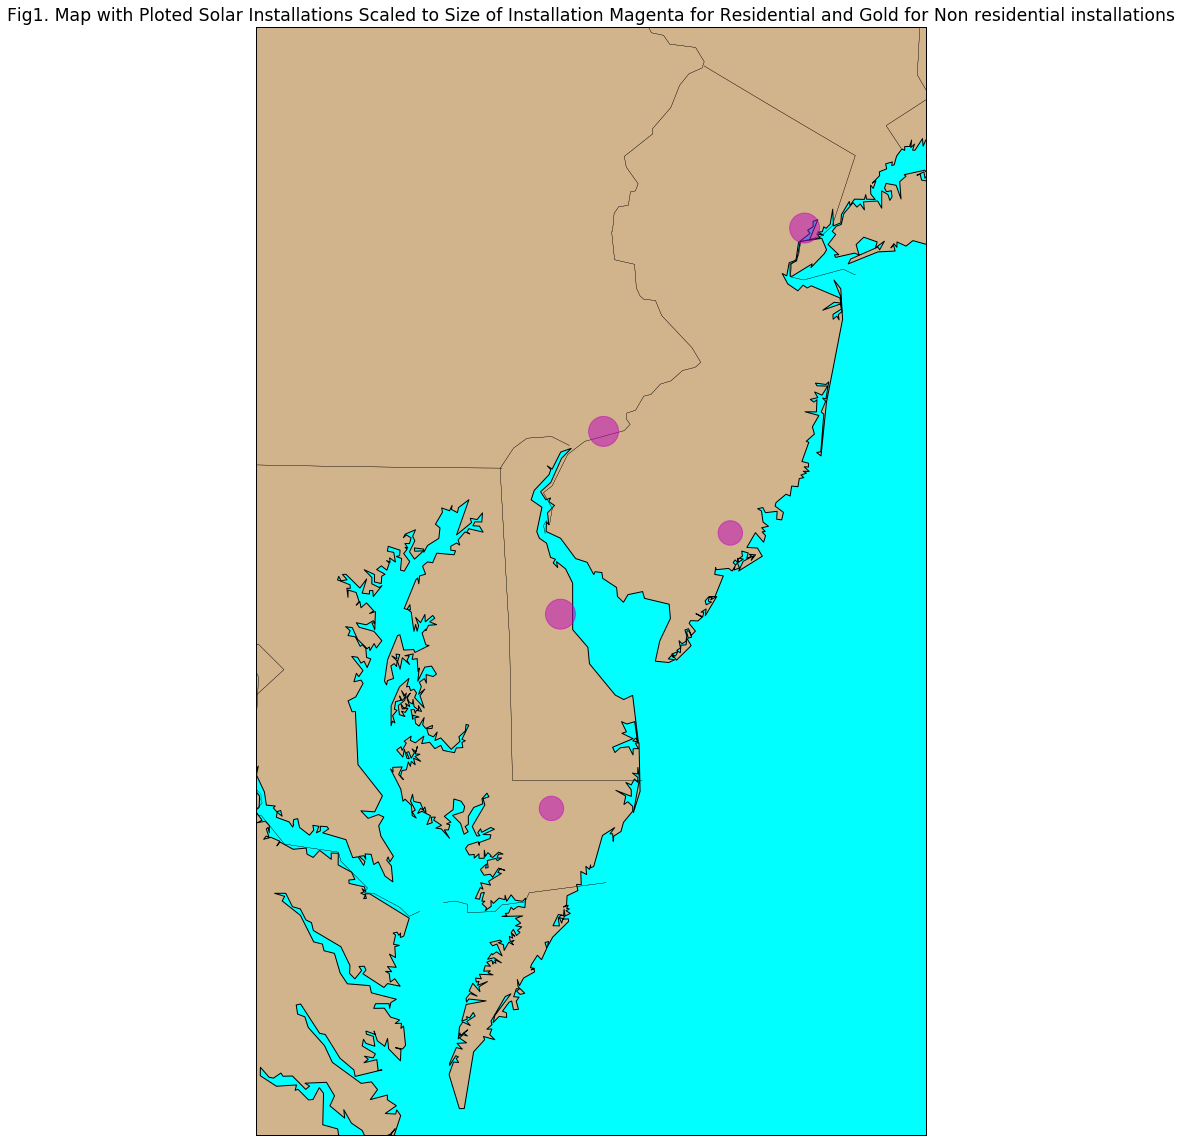

In [74]:
#isualize the Location of the airports 

#llcr=35.254916, -89.781679
#urcr=42.680216, -73.470890
#mid=39, -80

#Get county, state, solar pannel area, latitude and longitude data from Deep Solar Dataset
#energytype = Deep_Solar_df.loc[:,['county', 'state','lat', 'lon','total_panel_area',"total_panel_area_nonresidential","total_panel_area_residential"]]

#Determine figure size 
plt.figure(figsize=(12,24))

#create map lcc projection of united states 
map = Basemap(llcrnrlon=-77,llcrnrlat=37.,urcrnrlon=-73.5,urcrnrlat=41.5,resolution='i',projection='tmerc',lon_0=-75.25,lat_0=39)
#fill in colors draw boundries for countries and states 
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='tan',lake_color='blue')
map.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
map.drawstates(linewidth=0.25, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
map.drawcoastlines()

#map.drawparallels(np.arange(10,70,20),labels=[1,1,0,0])
#map.drawmeridians(np.arange(-100,0,20),labels=[0,0,0,1])
plt.title('Fig1. Map with Ploted Solar Installations Scaled to Size of Installation Magenta for Residential and Gold for Non residential installations', fontsize='xx-large')




lons = pjm_Airport_codes['lon'].to_numpy()
lats = pjm_Airport_codes['lat'].to_numpy()
#typ = pjm_Airport_codes['type'].to_numpy()

typ  = pjm_Airport_codes['type'] = pjm_Airport_codes['type'].apply(lambda x: 3 if x== 'large_airport'else(2 if x=='medium_airport'else 1)).to_numpy()

'large_airport','medium_airport','small_airport'
#x, y = map(lons, lats)
x, y = map(lons, lats)

colours = ['w','r','g','b']
#c = colours[typ.to_numpy()]

# plot points to map and scale to pannel area and color for residential and non
plt.scatter(x, y,s=typ*300,color='m', alpha=.5, zorder=9)

#plt.scatter(x, y,s=(energytype['total_panel_area_residential']/1000),color='m', alpha=.5, zorder=10)


plt.show()



In [114]:
pjm_Airport_codes.head(6)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lon,lat,working
1,KACY,2,Atlantic City International Airport,75.000000,NaN,US,US-NJ,Atlantic City,KACY,ACY,ACY,"[-74.57720184326172, 39.45759963989258]",-74.577202,39.457600,True
13,KDOV,3,Dover Air Force Base,24.000000,NaN,US,US-DE,Dover,KDOV,DOV,DOV,"[-75.46600342, 39.12950134]",-75.466003,39.129501,True
16,KEWR,3,Newark Liberty International Airport,18.000000,NaN,US,US-NJ,Newark,KEWR,EWR,EWR,"[-74.168701171875, 40.692501068115234]",-74.168701,40.692501,True
38,KORF,3,Norfolk International Airport,26.000000,NaN,US,US-VA,Norfolk,KORF,ORF,ORF,"[-76.20120239257812, 36.89459991455078]",-76.201202,36.894600,True
40,KPHL,3,Philadelphia International Airport,36.000000,NaN,US,US-PA,Philadelphia,KPHL,PHL,PHL,"[-75.24109649658203, 39.87189865112305]",-75.241096,39.871899,True
46,KSBY,2,Salisbury Ocean City Wicomico Regional Airport,52.000000,NaN,US,US-MD,Salisbury,KSBY,SBY,SBY,"[-75.51029968261719, 38.34049987792969]",-75.510300,38.340500,True


In [115]:
# create a list of airport coordinates
# already done :Pennsylvania, Washington_DC, Maryland, New_Jersey.Virginia, Deleware
US_State = str('Maryland')

#KPHL
US_State_dict={'Pennsylvania':'US-PA','Washington_DC':'US-DC','Maryland':'US-MD', 'New_Jersey':'US-NJ',
          'Virginia':'US-VA', 'Deleware':'US-DE'}
#iso_reg = US_State_dict[US_State]

subset = pd.DataFrame()
subset = pjm_Airport_codes[['lat', 'lon', 'gps_code','iso_region']].loc[lambda Airport_codes_df: Airport_codes_df['iso_region'] == US_State_dict[US_State]]
coordinates_airport = [list(x) for x in subset.to_numpy()]
print(len(coordinates_airport))

print(US_State,US_State_dict[US_State] )

pjm_Airport_codes.loc[lambda Airport_codes_df: Airport_codes_df['iso_region']==US_State_dict[US_State]].head()
print(coordinates_airport)

1
Maryland US-MD
[['38.340500', '-75.510300', 'KSBY', 'US-MD']]


In [116]:
#create a list of URLS to call the API with 


from datetime import datetime
from dateutil.rrule import rrule, DAILY, MONTHLY
from datetime import  timedelta

now = datetime.now() # current date and time

coordinates_airport

#test geocode 
#lat_airport = [40.188468]
#lon_airport = [-76.775258]

#YMD
#enter  the start and end date you would like to call from the API 
#startingDate = datetime(2014, 1, 1)
#EndingDate = datetime(2018,12,31)

#short version for code testing 
startingDate = datetime(1998, 1, 1)
EndingDate = datetime(2018,12,30)

2014,1,1-2018,12,30

#create a list of dates between the start and end date with month long increments 
startdates = (list(rrule(MONTHLY, dtstart=startingDate, until=EndingDate)))
enddates = []
#create a list of dates offset by (-)one day to mark the end of the month
for i, date in enumerate (startdates):
    enddates.append(startdates[i]- timedelta(days=1))

#enddates   = startdates - timedelta(days=1)


startdates =  [date.__str__() for date in startdates]
startdates = [date.replace('-','') for date in startdates]
startdates = [date.replace(' 00:00:00','') for date in startdates]

enddates =  [date.__str__() for date in enddates]
enddates = [date.replace('-','') for date in enddates]
enddates = [date.replace(' 00:00:00','') for date in enddates]

#create an empty list to store the URL dates in 
url_dates = []
# for each date insert the start and end date into the URL 

for j in range(len(coordinates_airport)):
        for i in range(len(startdates)-1):
            url_dates.append('https://api.weather.com/v1/geocode/{}/{}/observations/historical.json?apiKey=6532d6454b8aa370768e63d6ba5a832e&startDate={}&endDate={}&units=e'.format(coordinates_airport[j][0],coordinates_airport[j][1],startdates[i],enddates[i+1]))
    
    
#print(url_dates)
# the length of the URL dates should be approximatly be 12*num_years*num_airports
print(len(url_dates))


251


In [117]:
print(len(url_dates))

251


In [118]:
weather_df = pd.DataFrame()
responce  = requests.get(url_dates[0])
api = responce.json()
try:
    reading_df = pd.DataFrame(api["observations"])
    weather_df = weather_df.append(reading_df,ignore_index = True)
except KeyError:
    print(str(api))
    print(n,url_dates[n])
    for key in api.keys(): print(key)
        
print(api["observations"])

[{'key': 'KSBY', 'class': 'observation', 'expire_time_gmt': 883637400, 'obs_id': 'KSBY', 'obs_name': 'Salisbury', 'valid_time_gmt': 883630200, 'day_ind': 'N', 'temp': 27, 'wx_icon': 33, 'icon_extd': 3300, 'wx_phrase': 'Fair', 'pressure_tend': None, 'pressure_desc': None, 'dewPt': 10, 'heat_index': 27, 'rh': 51, 'pressure': 30.16, 'vis': 7, 'wc': 14, 'wdir': 340, 'wdir_cardinal': 'NNW', 'gust': None, 'wspd': 17, 'max_temp': None, 'min_temp': None, 'precip_total': None, 'precip_hrly': None, 'snow_hrly': None, 'uv_desc': 'Low', 'feels_like': 14, 'uv_index': 0, 'qualifier': None, 'qualifier_svrty': None, 'blunt_phrase': None, 'terse_phrase': None, 'clds': 'FEW', 'water_temp': None, 'primary_wave_period': None, 'primary_wave_height': None, 'primary_swell_period': None, 'primary_swell_height': None, 'primary_swell_direction': None, 'secondary_swell_period': None, 'secondary_swell_height': None, 'secondary_swell_direction': None}, {'key': 'KSBY', 'class': 'observation', 'expire_time_gmt': 883

In [119]:
weather_df = pd.DataFrame()


#with open('weather_data.json')as file:
for n in range(len(url_dates)):
        responce  = requests.get(url_dates[n])
        api = responce.json()
        try:
            reading_df = pd.DataFrame(api["observations"])
            weather_df = weather_df.append(reading_df,ignore_index = True)

        except KeyError:
            print(str(api))
            print(n,url_dates[n])
            for key in api.keys(): print(key)
        
        print(n,len(weather_df.index))
        time.sleep(.5)
        
     
#r  = requests.get('https://api.weather.com/v1/geocode/40.188468/-76.775258/observations/historical.json?apiKey=6532d6454b8aa370768e63d6ba5a832e&startDate=20140101&endDate=20140131&units=e')
print( len(weather_df.index))


0 843
1 1597
2 2514
3 3342
4 4281
5 5150
6 5965
7 6845
8 7654
9 8471
10 9237
11 10065
12 10922
13 11688
14 12502
15 13328
16 14177
17 15003
18 15802
19 16606
20 17362
21 18086
22 18846
23 19606
24 20347
25 20878
26 21620
27 22337
28 23095
29 23601
30 24385
31 24662
32 25439
33 26192
34 26906
35 27648
36 28405
37 29089
38 29845
39 30571
40 31594
41 32676
42 33691
43 34925
44 36027
45 36894
46 37879
47 38774
48 39667
49 40467
50 41468
51 42362
52 43318
53 44378
54 45343
55 46346
56 47463
57 48500
58 49472
59 50358
60 51261
61 52215
62 53263
63 54172
64 55246
65 56289
66 57428
67 58657
68 59765
69 60729
70 61728
71 62661
72 63563
73 64358
74 65264
75 66231
76 67216
77 68221
78 69440
79 70636
80 71796
81 72791
82 73728
83 74630
84 75639
85 76469
86 77384
87 78182
88 79173
89 80235
90 81482
91 82705
92 83767
93 84913
94 85716
95 86558
96 87494
97 88269
98 88945
99 89793
100 90661
101 91659
102 92754
103 93809
104 94934
105 95938
106 96973
107 97861
108 98753
109 99518
110 100339
111 101227


In [120]:
print(weather_df['blunt_phrase'].unique())
weather_df.head()
weather_df.info()

[None]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229609 entries, 0 to 229608
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   key                        229609 non-null  object 
 1   class                      229609 non-null  object 
 2   expire_time_gmt            229609 non-null  int64  
 3   obs_id                     229609 non-null  object 
 4   obs_name                   229609 non-null  object 
 5   valid_time_gmt             229609 non-null  int64  
 6   day_ind                    229609 non-null  object 
 7   temp                       228816 non-null  float64
 8   wx_icon                    229098 non-null  float64
 9   icon_extd                  229294 non-null  float64
 10  wx_phrase                  229098 non-null  object 
 11  pressure_tend              57828 non-null   float64
 12  pressure_desc              57828 non-null   object 
 13  dewPt                 

In [122]:
weather_df.drop(['qualifier_svrty',
                 'qualifier','blunt_phrase',
                 'terse_phrase','water_temp',
                 'primary_wave_period', 'primary_wave_height',
                 'primary_swell_period', 'primary_swell_height',
                 'primary_swell_direction', 'secondary_swell_period',
                 'secondary_swell_height', 'secondary_swell_direction'], axis=1)



,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,wx_phrase,pressure_tend,pressure_desc,dewPt,heat_index,rh,pressure,vis,wc,wdir,wdir_cardinal,gust,wspd,max_temp,min_temp,precip_total,precip_hrly,snow_hrly,uv_desc,feels_like,uv_index,clds
0,KSBY,observation,883637400,KSBY,Salisbury,883630200,N,27.000000,33.000000,"3,300.000000",Fair,nan,None,10.000000,27.000000,51.000000,30.160000,7.000000,14.000000,340.000000,NNW,nan,17.000000,nan,nan,None,None,None,Low,14.000000,0,FEW
1,KSBY,observation,883641000,KSBY,Salisbury,883633800,N,27.000000,33.000000,"3,300.000000",Fair,1.000000,Rising,7.000000,27.000000,43.000000,30.310000,15.000000,16.000000,320.000000,NW,nan,12.000000,31.000000,26.000000,None,None,None,Low,16.000000,0,CLR
2,KSBY,observation,883644600,KSBY,Salisbury,883637400,N,25.000000,33.000000,"3,300.000000",Fair,nan,None,10.000000,25.000000,54.000000,30.360000,15.000000,15.000000,330.000000,NNW,nan,9.000000,nan,nan,None,None,None,Low,15.000000,0,CLR
3,KSBY,observation,883648200,KSBY,Salisbury,883641000,N,25.000000,29.000000,"2,900.000000",Partly Cloudy,nan,None,7.000000,25.000000,46.000000,30.390000,15.000000,15.000000,330.000000,NNW,nan,9.000000,nan,nan,None,None,None,Low,15.000000,0,SCT
4,KSBY,observation,883651800,KSBY,Salisbury,883644600,N,23.000000,33.000000,"3,300.000000",Fair,1.000000,Rising,7.000000,23.000000,50.000000,30.410000,15.000000,13.000000,340.000000,NNW,nan,9.000000,nan,nan,None,None,None,Low,13.000000,0,CLR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229604,KSBY,observation,1543632840,KSBY,Salisbury,1543625640,N,40.000000,33.000000,"3,300.000000",Fair,nan,None,37.000000,40.000000,89.000000,30.010000,10.000000,36.000000,330.000000,NNW,nan,6.000000,nan,nan,NaN,0.000000,None,Low,36.000000,0,CLR
229605,KSBY,observation,1543636440,KSBY,Salisbury,1543629240,N,38.000000,33.000000,"3,300.000000",Fair,nan,None,36.000000,38.000000,93.000000,30.020000,10.000000,38.000000,nan,CALM,nan,0.000000,nan,nan,NaN,0.000000,None,Low,38.000000,0,CLR
229606,KSBY,observation,1543640040,KSBY,Salisbury,1543632840,N,39.000000,33.000000,"3,300.000000",Fair,1.000000,Rising,36.000000,39.000000,89.000000,30.040000,10.000000,39.000000,nan,CALM,nan,0.000000,nan,nan,NaN,0.000000,None,Low,39.000000,0,CLR
229607,KSBY,observation,1543643640,KSBY,Salisbury,1543636440,N,34.000000,33.000000,"3,300.000000",Fair,nan,None,33.000000,34.000000,96.000000,30.060000,9.000000,30.000000,210.000000,SSW,nan,5.000000,nan,nan,NaN,0.000000,None,Low,30.000000,0,CLR


In [123]:
print(len(Saved_weather_df.index))


NameError: name 'Saved_weather_df' is not defined

In [124]:
weather_df['time_dif']= weather_df['valid_time_gmt']-weather_df['expire_time_gmt']
#weather_df['timeA']= weather_df['valid_time_gmt'].diff(periods=1)
#weather_df['timeB'] = pd.to_datetime(weather_df['valid_time_gmt'],utc=True)
#weather_df['timeC'] = pd.to_datetime(weather_df['valid_time_gmt'],unit='s')

weather_df.insert(2,'date/time',pd.to_datetime(weather_df['expire_time_gmt'],unit='s'))

weather_df.tail()

,key,class,date/time,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,wx_phrase,pressure_tend,pressure_desc,dewPt,heat_index,rh,pressure,vis,wc,wdir,wdir_cardinal,gust,wspd,max_temp,min_temp,precip_total,precip_hrly,snow_hrly,uv_desc,feels_like,uv_index,qualifier,qualifier_svrty,blunt_phrase,terse_phrase,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction,time_dif
229604,KSBY,observation,2018-12-01 02:54:00,1543632840,KSBY,Salisbury,1543625640,N,40.000000,33.000000,"3,300.000000",Fair,nan,None,37.000000,40.000000,89.000000,30.010000,10.000000,36.000000,330.000000,NNW,nan,6.000000,nan,nan,NaN,0.000000,None,Low,36.000000,0,None,None,None,None,CLR,None,None,None,None,None,None,None,None,None,-7200
229605,KSBY,observation,2018-12-01 03:54:00,1543636440,KSBY,Salisbury,1543629240,N,38.000000,33.000000,"3,300.000000",Fair,nan,None,36.000000,38.000000,93.000000,30.020000,10.000000,38.000000,nan,CALM,nan,0.000000,nan,nan,NaN,0.000000,None,Low,38.000000,0,None,None,None,None,CLR,None,None,None,None,None,None,None,None,None,-7200
229606,KSBY,observation,2018-12-01 04:54:00,1543640040,KSBY,Salisbury,1543632840,N,39.000000,33.000000,"3,300.000000",Fair,1.000000,Rising,36.000000,39.000000,89.000000,30.040000,10.000000,39.000000,nan,CALM,nan,0.000000,nan,nan,NaN,0.000000,None,Low,39.000000,0,None,None,None,None,CLR,None,None,None,None,None,None,None,None,None,-7200
229607,KSBY,observation,2018-12-01 05:54:00,1543643640,KSBY,Salisbury,1543636440,N,34.000000,33.000000,"3,300.000000",Fair,nan,None,33.000000,34.000000,96.000000,30.060000,9.000000,30.000000,210.000000,SSW,nan,5.000000,nan,nan,NaN,0.000000,None,Low,30.000000,0,None,None,None,None,CLR,None,None,None,None,None,None,None,None,None,-7200
229608,KSBY,observation,2018-12-01 06:54:00,1543647240,KSBY,Salisbury,1543640040,N,33.000000,33.000000,"3,300.000000",Fair,nan,None,33.000000,33.000000,100.000000,30.070000,8.000000,33.000000,nan,CALM,nan,0.000000,52.000000,30.000000,NaN,0.000000,None,Low,33.000000,0,None,None,None,None,CLR,None,None,None,None,None,None,None,None,None,-7200


In [125]:


filename = r'/Users/robertshiles/CSV_files/weather_data_{}.csv'.format('KSBY')
weather_df.to_csv(filename, index = False)
